## Question 1: Propensity score matching

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

In [2]:
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets,interact
from IPython.display import display

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

In [3]:
path = './lalonde.csv'
dataset = pd.read_csv(path)

In [34]:
display(dataset.head(10))

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899
5,NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940
6,NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000
7,NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580
8,NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220
9,NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.0700


In [5]:
copyDS = dataset.copy()
''' 
Here we want to see the distribution of the subject participated in the job training program and the ones that didn't.
We will do two box plot an analyse them.
'''

NSW = dataset.loc[copyDS['treat'] == 1]['re78'] # participated in the job training program
PSID = dataset.loc[copyDS['treat'] == 0]['re78'] # Didn't participated in the job training program

In [32]:
#Quantifing the amount of 0 in the each group
NSWZeros = np.where(NSW == 0.0)[0]
PSIDZeros = np.where(PSID == 0)[0]

print('There are ' + str(len(NSWZeros)) + ' zeros in NSW and ' + str(len(PSIDZeros)) + ' in PSID')

There are 45 zeros in NSW and 98 in PSID


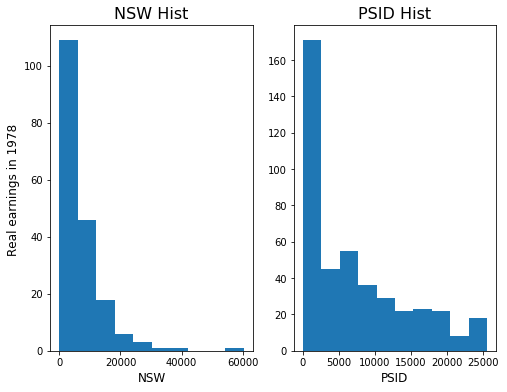

In [14]:
plt.figure(figsize=(8, 6)) 

plt.subplot(1, 2, 1)
histNSW = plt.hist(NSW.tolist())
plt.title('NSW Hist',fontsize=16)
plt.ylabel('Real earnings in 1978 ',fontsize=12)
plt.xlabel('NSW',fontsize=12)

plt.subplot(1, 2, 2)
histPSID = plt.hist(PSID.tolist())
plt.title('PSID Hist',fontsize=16)
plt.xlabel('PSID',fontsize=12)


plt.show()

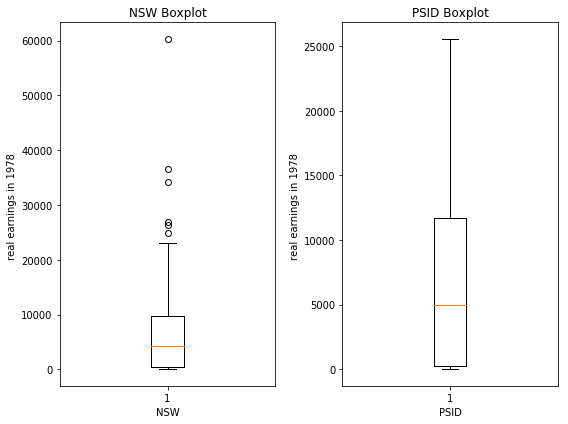

In [7]:
# multiple box plots on one figure
plt.figure(figsize=(8, 6)) 
plt.subplot(1, 2, 1)
plt.boxplot(NSW.tolist(),0)
plt.title('NSW Boxplot')
plt.ylabel('real earnings in 1978 ')
plt.xlabel('NSW')

plt.subplot(1, 2, 2)
plt.boxplot(PSID.tolist(),0)
plt.title('PSID Boxplot')
plt.ylabel('real earnings in 1978 ')
plt.xlabel('PSID')


plt.tight_layout()
plt.show()

At first sight, we could say that both histograms and  box plot are very similar. The only difference is that the NSW data have some outliers. However, it's highly possible that those outliers play an important role. As seen in the lecture, some distributions are all about the “outliers”.


#### 2. A closer look at the data

#### 3. A propensity score model

#### 4. Balancing the dataset via matching

#### 5. Balancing the groups further

#### 6. A less naive analysis

## Question 2: Applied ML